# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://colab.research.google.com/drive/1JlW6P5PkrIx_HthNfab5mc0Lm2RsK2bK?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
!pip install -U torch==1.13.1+cu116 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html
#this has been installed according to a piazza post as the line provided befire in the lab was providing errors.

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
# Open the file and read the lines
with open('/content/SMSSpamCollection', 'r') as file:
    # Print the first 5 lines to see how the labels and messages look like
    for i in range(5):
        line = file.readline()
        print(line)

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though



In [ ]:
#after printing out the sample statements above, I can see that the labels for
spam_example = None
non_spam_example = None
for line in open('SMSSpamCollection'):
  label, message = line.split('\t', 1)
  if label == 'spam' and spam_example is None:
    spam_example = message.strip()
  elif label == 'ham' and non_spam_example is None:
    non_spam_example = message.strip()
  # Break if we have found both examples
  if spam_example and non_spam_example:
    break

# Print the examples
print(f"Spam example:\nLabel: spam\nMessage: {spam_example}\n")
print(f"Non-spam example:\nLabel: ham\nMessage: {non_spam_example}\n")

# Print unique labels in the dataset
unique_labels = {'spam', 'ham'}
print(f"Unique labels: {unique_labels}")


Spam example:
Label: spam
Message: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Non-spam example:
Label: ham
Message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Unique labels: {'spam', 'ham'}


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
spam_count=0
non_spam_count=0
for line in open('SMSSpamCollection'):
  label, message = line.split('\t', 1)
  if label =='spam':
    spam_count +=1
  if label =="ham":
    non_spam_count +=1

# Print the counts
print(f"Number of spam messages: {spam_count}")
print(f"Number of non-spam messages: {non_spam_count}")

Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

These points have been developed after conducting further research into what character level models are and how they function.

Let's take a look at the advantages of modelling SMS text messages as a character level models:
1. Character level models are proven to be better at handling OOV (out of vocabulary) words, as they don't rely on a pre-defined set of words/vocabulary. This basically means that newly introduced words will also be taken in and processed as characters. This is particularly helpful when dealing with text messages, as they contain a lot of informal language. Text messages often involve the use of slang words, such as "wanna", "gonna", "sorta", etc. Such words do not exist in the vocabulary, but the model can still break them down as characters.

2. Character level models are better at capturing typos and spelling mistakes, as each character is processed seperately.

Now, the disadvanatges are discussed:
1. Character level models would need to process much longer sequences. Invariablythis can increase computational complexity and memory power and storage. For example in "Deep learning is fun!", a word-level model would process 4 tokens whereas the character level model would process 18 tokens.
2. It is possible that a character-level model might struggle to capture high-level contexts between the words in sentence, as the focus is only on individual characters.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext
# I read the torchtext documentation for the following
text_field = torchtext.data.Field(sequential=True,
                                  tokenize=lambda x: x,
                                  include_lengths=True,
                                  batch_first=True,
                                  use_vocab=True)
label_field = torchtext.data.Field(sequential=False,
                                   use_vocab=False,
                                   is_target=True,
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam'))

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection",
                                        "tsv",
                                        fields)

train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

***Answer: *** If the model contains significantly more non-spam messages than spam messages, the model will become bias towards predicting the bias class. By balancing the dataset, the model is exposed to an equal representation of both the classes, to ensure that the model learns to accurately recognize both the classes (non-spam and spam messages).

A balanced dataset will lead to more improved model performance and generalization.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
text_field.vocab.stoi
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 '0',
 'd',
 '.',
 'c',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 'b',
 '2',
 'T',
 '8',
 'k',
 'E',
 'v',
 '5',
 'S',
 'C',
 'I',
 'O',
 '4',
 'N',
 'A',
 '7',
 '3',
 'x',
 'R',
 '6',
 '!',
 ',',
 'P',
 '9',
 'U',
 'M',
 'W',
 'L',
 'H',
 'D',
 'B',
 'G',
 'F',
 'Y',
 '/',
 '?',
 "'",
 '£',
 '-',
 '&',
 'X',
 ':',
 'z',
 'V',
 'K',
 'j',
 '*',
 ')',
 ';',
 'J',
 '+',
 '(',
 '"',
 '#',
 'Q',
 'q',
 '>',
 '@',
 '=',
 'ü',
 'Z',
 'Ü',
 '|',
 '$',
 '<',
 '_',
 '\x92',
 '‘',
 '¡',
 '“',
 '%',
 '…',
 '[',
 ']',
 '\x93',
 'ú',
 '\x94',
 '\\',
 '–',
 '~',
 '\x96',
 '’',
 '\x91',
 'è',
 '—',
 '┾',
 '〨',
 '鈥']

**Answer**: After looking it up online, it was found that stroi stands for string to index mapping. The variable text_field.vocab.stoi, represents the mapping from text tokens to their relevant integer indices. It is also important to note that each token has a unique index. Note: it is stored as a dictionary.

itos stands for index to string, and the variable text_field.vocab.itos represents the integer index that is assigned to a text token.





### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

1. unk stands for unknown token. This basically represents any possible word or character that was not "seen" or processed. If the model encounters an unfamiliar word or token, it will label it as unk.

2. pad stands for a padding token. pad ensures that padded tokens are added to shorter sequences to ensure uniform and equal sequence length across all batches.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
# got the following syntax for BucketIterator from reading the torchtext documentation
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), #
                                           sort_within_batch=True,
                                           repeat=False)

In [ ]:
# function to count padding tokens and find maximum length in a batch
def compute_padding_and_max_length(padded_texts, pad_idx):
    # padded_texts is a tensor of shape [batch_size, max_seq_length]
    max_length = padded_texts.size(1)  # Get the length of the longest sequence in the batch
    num_pads = (padded_texts == pad_idx).sum().item()  # Count the number of pad tokens
    return max_length, num_pads

# Define the index for <pad> token
pad_idx = text_field.vocab.stoi['<pad>']
batch_counter = 0
# Iterate through DataLoader
for batch in train_iter:
    padded_texts = batch.sms[0]  # Get the padded texts tensor

    # this is computing the max length for each batch
    max_length, num_pads = compute_padding_and_max_length(padded_texts, pad_idx)
    print(f"Batch {batch_counter + 1}:")
    print(f"Max input length in this batch: {max_length}")
    print(f"Number of <pad> tokens in this batch: {num_pads}")
    print()

    batch_counter += 1

    # just do till 10 loops
    if batch_counter >= 10:
        break

Batch 1:
Max input length in this batch: 122
Number of <pad> tokens in this batch: 25

Batch 2:
Max input length in this batch: 159
Number of <pad> tokens in this batch: 0

Batch 3:
Max input length in this batch: 81
Number of <pad> tokens in this batch: 54

Batch 4:
Max input length in this batch: 104
Number of <pad> tokens in this batch: 70

Batch 5:
Max input length in this batch: 154
Number of <pad> tokens in this batch: 0

Batch 6:
Max input length in this batch: 163
Number of <pad> tokens in this batch: 28

Batch 7:
Max input length in this batch: 150
Number of <pad> tokens in this batch: 13

Batch 8:
Max input length in this batch: 49
Number of <pad> tokens in this batch: 19

Batch 9:
Max input length in this batch: 146
Number of <pad> tokens in this batch: 4

Batch 10:
Max input length in this batch: 38
Number of <pad> tokens in this batch: 7



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class RNN(nn.Module):
  #the model is taken from lecture 7
  def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(RNN, self).__init__()
        self.name = "rnn"
        self.emb = torch.eye(len(text_field.vocab.itos)) #each row will be represented as a one-hot encoded vector
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(len(text_field.vocab.itos), hidden_size, batch_first=True)#input size is the length of the vocabulary
        self.fc = nn.Linear(hidden_size, 2) # 2 is the num_classes, spam and no_spam. fully connected layer
  def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size) #initialize hidden state to 0
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1] #keep dimensions
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
import matplotlib.pyplot as plt

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    epochs = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        avg_train_loss = 0

        # Training loop
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item()

        avg_train_loss /= len(train)

        # Compute training accuracy
        model.eval()  # Set model to evaluation mode
        train_accuracy = get_accuracy(model, train)
        valid_accuracy = get_accuracy(model, valid)

        # Compute validation loss
        valid_loss = 0
        with torch.no_grad():
            for sms, labels in valid:
                pred = model(sms[0])
                loss = criterion(pred, labels)
                valid_loss += loss.item()

        valid_loss /= len(valid)

        # Store metrics
        train_losses.append(avg_train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_accuracy)
        valid_accs.append(valid_accuracy)
        epochs.append(epoch + 1)

        print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Val Loss {valid_loss:.4f}, Train Acc {train_accuracy:.4f}, Val Acc {valid_accuracy:.4f}")

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, valid_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Training Accuracy")
    plt.plot(epochs, valid_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1: Train Loss 0.6830, Val Loss 0.6986, Train Acc 0.6621, Val Acc 0.5067
Epoch 2: Train Loss 0.5294, Val Loss 0.2957, Train Acc 0.9051, Val Acc 0.9372
Epoch 3: Train Loss 0.2991, Val Loss 0.2137, Train Acc 0.9106, Val Acc 0.9453
Epoch 4: Train Loss 0.2974, Val Loss 0.2472, Train Acc 0.9340, Val Acc 0.9318
Epoch 5: Train Loss 0.2313, Val Loss 0.2855, Train Acc 0.9426, Val Acc 0.9211
Epoch 6: Train Loss 0.2575, Val Loss 0.2120, Train Acc 0.9266, Val Acc 0.9471
Epoch 7: Train Loss 0.2191, Val Loss 0.2169, Train Acc 0.9459, Val Acc 0.9462
Epoch 8: Train Loss 0.9190, Val Loss 0.6806, Train Acc 0.7010, Val Acc 0.5803
Epoch 9: Train Loss 0.5531, Val Loss 0.4003, Train Acc 0.8984, Val Acc 0.9166
Epoch 10: Train Loss 0.3007, Val Loss 0.2638, Train Acc 0.9447, Val Acc 0.9175
Epoch 11: Train Loss 0.2174, Val Loss 0.1776, Train Acc 0.9206, Val Acc 0.9516
Epoch 12: Train Loss 0.2272, Val Loss 0.2201, Train Acc 0.9378, Val Acc 0.9220
Epoch 13: Train Loss 0.2079, Val Loss 0.2358, Train Acc 0.947

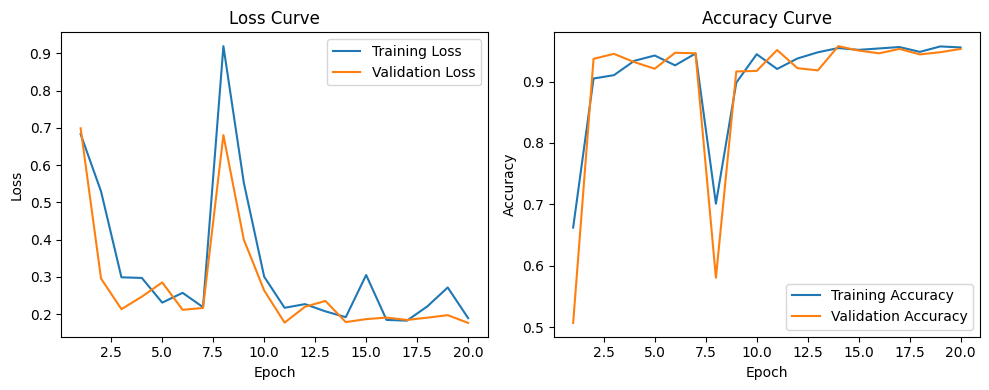

In [ ]:
RNN_1 = RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
train_rnn_network(RNN_1, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
# First hyperparameter tuning: changed num_epochs from 20 to 30; changed learning rate
# from 1e-4 to 1e-5, to see if a slower learning rate allows for better accuracy
#RNN_2= RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
#train_rnn_network(RNN_2, train_iter, valid_iter, num_epochs=30, learning_rate=1e-5)
#results: validation accuracy= 91.25%, validation loss= 0.1804. The training and validation loss curve seems to
# smooth and the there is a sudden spike in the validation accracy after the 10th epoch.

#Second hyperparameter tuning: kept num_epochs to 30 and learning rate as 1e-5, as it led to
#better accuracies. In this tuning, I will be changing the hidden_size value, but still keeping the num_layers as 1.
#RNN_3= RNN(len(text_field.vocab.itos), hidden_size=50, n_layers=1)
#train_rnn_network(RNN_3, train_iter, valid_iter, num_epochs=30, learning_rate=1e-5)
#results: validation accuracy= 89.78%. This change in hidden_size led to a a decrease in the
#validation accuracy. Large hidden sizes introduces more parameters, leading to overfitting and
#poor generalization in the model. the training and validation losses happened to follow a smooth curve.

#Third hyperparameter tuning: I will be reducing the number of hidden layers to see if that impacts the validation
#accuracy. This time, the number of layers has been icnreased from 1 to 3 to observe a difference.
#results: Validation Accuracy=  85.208%
#The results were quite surprising as the validation accuracy started as 16.95% and then started to increase after the 15t epoch.
#It is also important to note that the val errors were also considerably higher when compared to the other models.
#RNN_4= RNN(len(text_field.vocab.itos), hidden_size=30, n_layers=3)
#train_rnn_network(RNN_4, train_iter, valid_iter, num_epochs=30, learning_rate=1e-5)

#As increasing the num of layers while increasing the hidden_size to 30 provided weaker validation accuracies,
#it was important to observe the effect of simply increasing the number of layers.
#RNN_5= RNN(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=5)
#train_rnn_network(RNN_5, train_iter, valid_iter, num_epochs=30, learning_rate=1e-5)
#results: Validation Accuracy: 94.26%.

#The next tuning deals with slightly changing the archietcture of the RNN itself. Here is the new RNN model for the purposes
#of the test: This RNN model constains an additional fully connected layer called f1.
# class RNN_2(nn.Module):
#     def __init__(self, vocab_size, hidden_size, n_layers=1):
#         super(RNN_2, self).__init__()
#         self.name = "RNN_2"
#         self.emb = torch.eye(vocab_size)
#         self.hidden_size = hidden_size
#         self.rnn = nn.RNN(vocab_size, hidden_size, num_layers=n_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, hidden_size // 2)  # Additional fully connected layer
#         self.fc2 = nn.Linear(hidden_size // 2, 2)  # Final fully connected layer

#     def forward(self, x):
#         x = self.emb[x]
#         h0 = torch.zeros(1, x.size(0), self.hidden_size)
#         out, _ = self.rnn(x, h0)

#         # Using the output from the last time step
#         out = out[:, -1, :]

#         # Passing through additional fully connected layers
#         out = F.relu(self.fc1(out))
#         out = self.fc2(out)
#         return out
#The number of layers was switched back to 1 as it provided better results in the past, and the hidden_size was set to the
#original as well.
# RNN_6 = RNN_2(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
# train_rnn_network(RNN_6, train_iter, valid_iter, num_epochs=30, learning_rate=1e-5)
#Results: validation accuracy: 92.74% Validation Loss: 0.2164
#RESULTED IN BEST VALIDATION ACCURACY AND LOWEST VALIDATION LOSS ^

Epoch 1: Train Loss 0.6983, Val Loss 0.6542, Train Acc 0.4768, Val Acc 0.8628
Epoch 2: Train Loss 0.6972, Val Loss 0.6565, Train Acc 0.4768, Val Acc 0.8628
Epoch 3: Train Loss 0.6956, Val Loss 0.6569, Train Acc 0.4768, Val Acc 0.8628
Epoch 4: Train Loss 0.6944, Val Loss 0.6582, Train Acc 0.4768, Val Acc 0.8628
Epoch 5: Train Loss 0.6930, Val Loss 0.6612, Train Acc 0.4768, Val Acc 0.8628
Epoch 6: Train Loss 0.6916, Val Loss 0.6620, Train Acc 0.4768, Val Acc 0.8628
Epoch 7: Train Loss 0.6901, Val Loss 0.6624, Train Acc 0.4768, Val Acc 0.8628
Epoch 8: Train Loss 0.6885, Val Loss 0.6651, Train Acc 0.5088, Val Acc 0.8619
Epoch 9: Train Loss 0.6865, Val Loss 0.6665, Train Acc 0.5813, Val Acc 0.8664
Epoch 10: Train Loss 0.6836, Val Loss 0.6673, Train Acc 0.6895, Val Acc 0.8547
Epoch 11: Train Loss 0.6796, Val Loss 0.6709, Train Acc 0.7537, Val Acc 0.8278
Epoch 12: Train Loss 0.6731, Val Loss 0.6719, Train Acc 0.7733, Val Acc 0.7901
Epoch 13: Train Loss 0.6553, Val Loss 0.6575, Train Acc 0.818

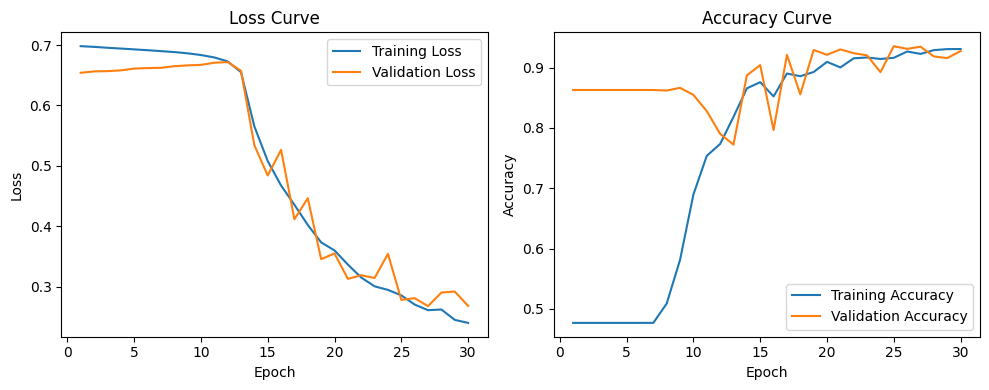

In [ ]:
#the best model running
class RNN_2(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(RNN_2, self).__init__()
        self.name = "RNN_2"
        self.emb = torch.eye(vocab_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(vocab_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)  # Additional fully connected layer
        self.fc2 = nn.Linear(hidden_size // 2, 2)  # Final fully connected layer

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)

        # Using the output from the last time step
        out = out[:, -1, :]

        # Passing through additional fully connected layers
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

RNN_6 = RNN_2(len(text_field.vocab.itos), len(text_field.vocab.itos), n_layers=1)
train_rnn_network(RNN_6, train_iter, valid_iter, num_epochs=30, learning_rate=1e-5)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
# valid_spam = torchtext.legacy.data.Dataset(
#     [e for e in valid.examples if e.label == 1],
#     valid.fields)
# Create a Dataset of only non-spam validation examples
# valid_nospam = None # TODO
# NOTE: I had to comment the code provided above as the version of torchtext I was using was not compatible
# and was providing me with errors
from torchtext.data import Dataset, BucketIterator

# Create a Dataset of only spam validation examples
valid_spam = Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields
)

# Create a Dataset of only non-spam validation examples
valid_nospam = Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields
)

def get_error_rate(model, data_iter):
    """Compute the error rate of the `model` on the dataset provided by `data_iter`."""
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    for batch in data_iter:
        sms, labels = batch.sms[0], batch.label
        output = model(sms)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return 1 - correct / total  # Return error rate

# Create iterators for the new datasets
spam_iter = BucketIterator(
    valid_spam, batch_size=32, sort_key=lambda x: len(x.sms),
    sort_within_batch=True, repeat=False
)

nospam_iter = BucketIterator(
    valid_nospam, batch_size=32, sort_key=lambda x: len(x.sms),
    sort_within_batch=True, repeat=False
)

model = RNN_6
fpr = get_error_rate(model, nospam_iter) #false positive rate
print(f"False Positive Rate (FPR): {fpr:.4f}")

fnr = get_error_rate(model, spam_iter) #false negative rate
print(f"False Negative Rate (FNR): {fnr:.4f}")


False Positive Rate (FPR): 0.0748
False Negative Rate (FNR): 0.1176


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

If the message happened to be false-positive, it means that in reality it was a non-spam message but the model predicts it as a spam-message. This could potentially cuase the user to miss out on important and personal messages as they will be wrongly sent to the spam folder.
Likewise, if a message happens to be false negative, it means that in reality, the message was a spam message, but the model predicted it to be a non-spam message. This would mean that harmful messages, such as phishing scams,could reach the user's inbox.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

test_accuracy= get_accuracy(RNN_6,test_iter)
print(f"The final test accuracy is: {test_accuracy*100:.2f}%")

The final test accuracy is: 93.45%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam test examples
test_spam = Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields
)

# Create a Dataset of only non-spam test examples
test_nospam = Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields
)

def get_error_rate(model, data_iter):
    """Compute the error rate of the `model` on the dataset provided by `data_iter`."""
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    for batch in data_iter:
        sms, labels = batch.sms[0], batch.label
        output = model(sms)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return 1 - correct / total  # Return error rate

# Create iterators for the new test datasets
spam_iter = BucketIterator(
    test_spam, batch_size=32, sort_key=lambda x: len(x.sms),
    sort_within_batch=True, repeat=False
)

nospam_iter = BucketIterator(
    test_nospam, batch_size=32, sort_key=lambda x: len(x.sms),
    sort_within_batch=True, repeat=False
)

# Calculate the false positive rate (FPR) and false negative rate (FNR)
model = RNN_6  # Use the trained model


fpr = get_error_rate(model, nospam_iter) #false positive rate
print(f"False Positive Rate (FPR): {fpr:.4f}")


fnr = get_error_rate(model, spam_iter) #false negative rate
print(f"False Negative Rate (FNR): {fnr:.4f}")

False Positive Rate (FPR): 0.0586
False Negative Rate (FNR): 0.2128


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
#tokenize the message
tokens = text_field.preprocess(msg)
#convert tokens to indices
token_indices = [text_field.vocab.stoi[token] for token in tokens]
#Convert indices to a tensor
msg_tensor = torch.LongTensor(token_indices).unsqueeze(1)  # Adding a batch dimension
#evaluate the model
with torch.no_grad():  # No need to calculate gradients for inference
    output = RNN_6(msg_tensor)
    probabilities = torch.softmax(output, dim=1)  # Assuming the model outputs logits

#probability of the message being spam
spam_probability = probabilities[0][1].item()  # Assuming the second column corresponds to spam

print(f"The probability that the message \"{msg}\" is spam is: {spam_probability:.4f}")

The probability that the message "machine learning is sooo cool!" is spam is: 0.5195


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think the spam detection can be an easy and a hard task depending on the complexity of the text messages. If there are common keywords that are heavily associated with spam messages, the spam detection becomes fairly easy. However, there are also some phishing messages that appear to be quite legitimate. Classifying phishing messages can be challenging because many words and phrases may appear to be from authentic messages.

A core concept surrounding the baseline model would be a keyword filter. The steps and general architecture of the baseline model are discussed below:

1. We are first going to inititae a list of commonly recognized spam words. For example, the list will include words such as "free", "money", "win", "lottery", "vacation","holiday","gift",  etc. ex.
common_spam_words= [free, money,gift,lottery,win,vacation,holiday]
2. The message will then be tokenized into individual words (tokens). Tokenizing will make it easier for the direct comparison to the common_spam_words list.
3. Initialize a counter for keeping track of many spam words have been identified.Iterate through the tokenized message and see if any words match with the list.The counter will be updated accordingly, and if the counter ends up having a value of 3 or more, it would be classified as a spam message.